# Setup

In [8]:
import matplotlib.pyplot as plt
import os
import json
import xml.etree.ElementTree
import scipy.misc
import numpy as np
import pickle
import random

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Utils

In [10]:
# Recursively print all folders (to view data format)
def recursive_print(folder_name, tabs=''):
    sub_folders = [x for x in os.listdir(folder_name) if os.path.isdir(folder_name+'/'+x)]
    if len(sub_folders)==0:
        print(tabs+folder_name+": "+str(len([x for x in os.listdir(folder_name)])))
    else:
        for sub_folder in sub_folders:
            print(tabs+sub_folder)
            recursive_print(folder_name+"/"+sub_folder, tabs+"\t")
    
#recursive_print('.')

In [11]:
# Convert XML to nested dictionary
def xml_to_dict(path):
    def xml_to_dict_recursive(node):
        if len(node)==0:
            return node.text
        return {child.tag:xml_to_dict_recursive(child) for child in node}
    return xml_to_dict_recursive(xml.etree.ElementTree.parse(path).getroot())

# Pretty print XML dictionary
def print_xml(xml_dict):
    print(json.dumps(a, indent=4, sort_keys=True))

### Load Data

In [5]:
# Load images and labels from both datasets (Returns dictionary of dictionaries)
def load_data():
    dataset1_path = "./dataset 1"
    dataset2_path = "./dataset 2(only lp)/41082077licence_img"
    
    def load_images(path, key=lambda x: int(x.split('.')[0])):
        return [scipy.misc.imread(path+"/"+file_name) for file_name in sorted(os.listdir(path),key=key)]
    
    def load_xmls(path):
        return [xml_to_dict(path+"/"+file_name) for file_name in sorted(os.listdir(path),key=lambda x: int(x.split('.')[0]))]
                
    # Convert Images to numpy array
    db_paths = { "ac":dataset1_path+"/Subset_AC/AC/",
                 "le":dataset1_path+"/Subset_LE/LE/",
                 "rp":dataset1_path+"/Subset_RP/RP/" }
    
    dataset1_output = { db_name:
                           {'Xtrain':load_images(db_path+"train/jpeg"),
                            'Xtest':load_images(db_path+"test/jpeg"),
                            'ytrain':load_xmls(db_path+"train/xml"),
                            'ytest':load_xmls(db_path+"test/xml") }
                       for db_name, db_path in db_paths.items()}
    
    dataset2_output = {'X':load_images(dataset2_path, key=lambda x:x),
                       'y':[x.split('.')[0] for x in sorted(os.listdir(dataset2_path),key=lambda x:x)]}
    
    return dataset1_output, dataset2_output
        
raw_data1, raw_data2 = load_data()

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


In [6]:
# Make modifications on the raw data formats (ex: remove extra XML fields)
def convert_data(raw_data):
    def convert_xml(xml_dict_array):
        return [{'plate':xml_dict['object']['platetext'],
                 'box':{y:int(xml_dict['object']['bndbox'][y]) for y in xml_dict['object']['bndbox']}} for xml_dict in xml_dict_array]
    data=dict()
    for data_folder in raw_data: # ac, le, or rp
        data[data_folder] = {'Xtrain':raw_data[data_folder]['Xtrain'],
                            'Xtest':raw_data[data_folder]['Xtest'],
                            'ytrain':convert_xml(raw_data[data_folder]['ytrain']),
                            'ytest':convert_xml(raw_data[data_folder]['ytest'])}
    return data
data1, data2 = convert_data(raw_data1), raw_data2

# Checkpoint 1 (Load/Save Data)

In [12]:
data_save_dir = "saved datasets"
data_name = "version2"

if not os.path.isdir(data_save_dir):
    os.makedirs(data_save_dir)
    
dataset1_path = os.path.join(data_save_dir, data_name+"_dataset1.p")
dataset2_path = os.path.join(data_save_dir, data_name+"_dataset2.p")

### Save Data

In [8]:
with open(dataset1_path, 'wb') as fp:
    pickle.dump(data1, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(dataset2_path, 'wb') as fp:
    pickle.dump(data2, fp, protocol=pickle.HIGHEST_PROTOCOL)

### Load Data

In [47]:
with open(dataset1_path, 'rb') as fp:
    data1 = pickle.load(fp)
with open(dataset2_path, 'rb') as fp:
    data2 = pickle.load(fp)

# Visualize Examples of each Dataset

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


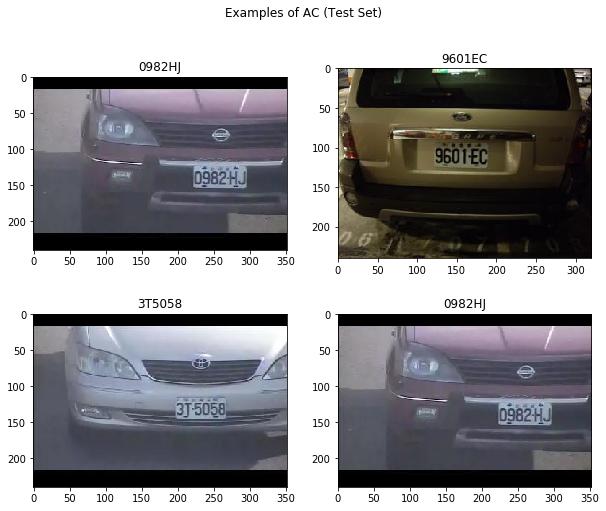

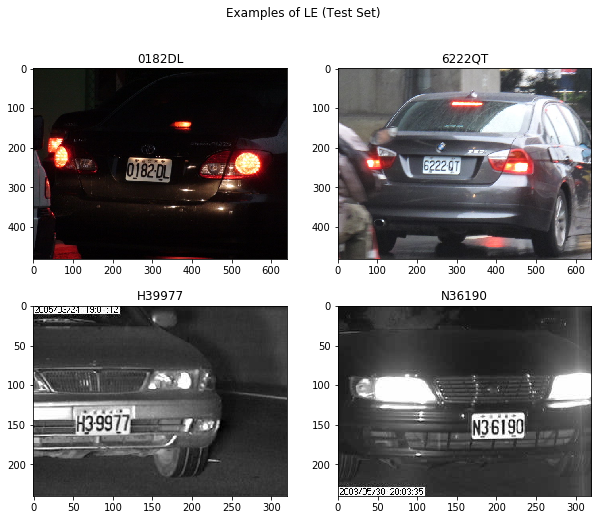

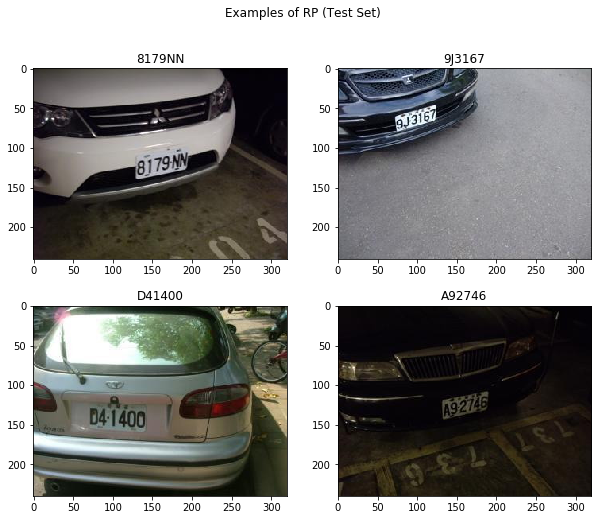

In [14]:
for i, data1_name in enumerate(data1.keys()):
    fig = plt.figure()
    fig.suptitle("Examples of "+data1_name.upper()+" (Test Set)")
    for img_num in range(4):
        rand_img = random.randint(0,len(data1[data1_name]['Xtrain']))
        ax = fig.add_subplot(2,2,img_num+1)
        ax.imshow(data1[data1_name]['Xtrain'][rand_img],interpolation='nearest')
        ax.set_title(data1[data1_name]['ytrain'][rand_img]['plate']);
    fig.show()

# Visualize Examples of each Dataset (with bounding boxes)

#### Import Open CV (tested with python3 version of OpenCV)

In [48]:
import cv2
import copy

#### Custom draw function

In [54]:
def draw_result(ax, input_img, boxes, plates, certainties=None):
    # make a copy of the img:
    img = copy.deepcopy(input_img)
    
    # should only be one result...bc we are assuming one plate per image
    for i, box in enumerate(boxes):
        xmin = int(box['xmin'])
        xmax = int(box['xmax'])
        ymin = int(box['ymin'])
        ymax = int(box['ymax'])
        
        # set outline shape
        w = (xmax - xmin) // 2
        h = (ymax - ymin) // 2
        x = xmax - w
        y = ymax - h
        
        # set text box width
        min_text_w = 40
        txt_w = w if w > min_text_w else min_text_w
        
        # set font:
        tune_param = 0.9
        fontScale = (img.shape[0] * img.shape[1]) / (1000 * 1000) * tune_param
        
        # draw text box
        textbox_color = (255, 255, 255)
        cv2.rectangle(img, (x - w, y - h), (x + w, y + h), (0, 255, 0), 2)
        cv2.rectangle(img, (x - w, y - h - 20), (x + txt_w, y - h), textbox_color, -1)
        
        if certainties is None:
            cv2.putText(img, plates[i], (x - w + 3, y - h - 7),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        else:
            cv2.putText(img, plates[i] + ' : %.2f' % certainties[i], (x - w + 3, y - h - 7),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            
    # add to matplotlib ax:
    ax.imshow(img, interpolation='nearest')

#### Duplicated code from above

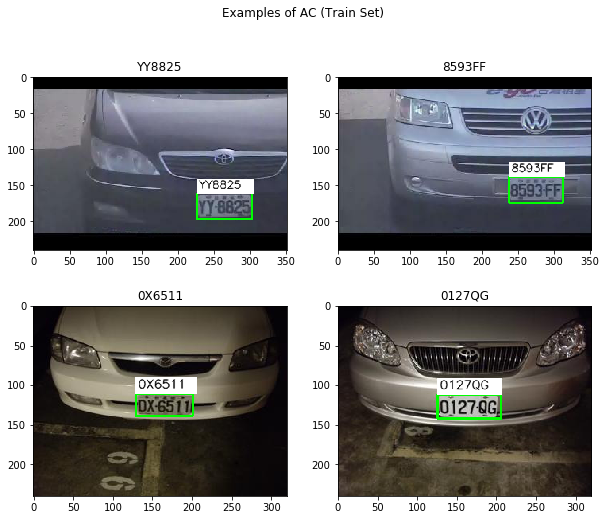

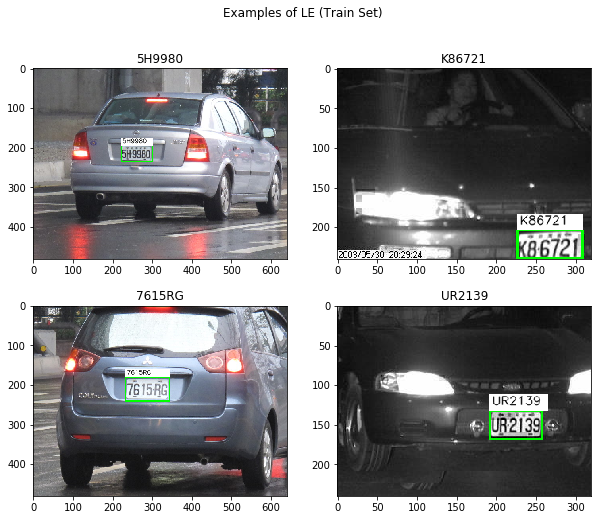

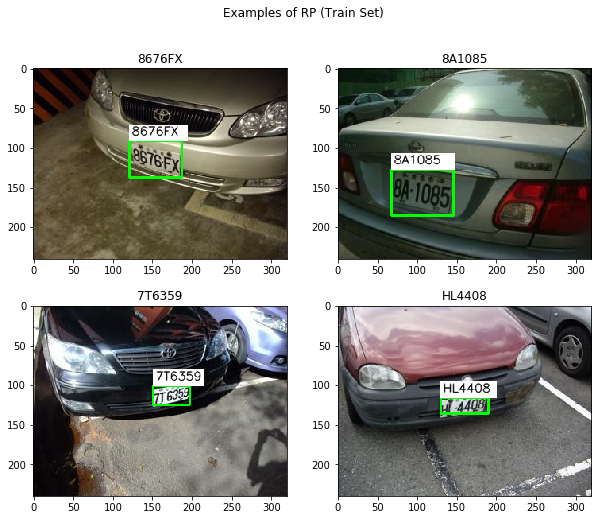

In [55]:
for i, data1_name in enumerate(data1.keys()):
    fig = plt.figure()
    fig.suptitle("Examples of "+data1_name.upper()+" (Train Set)")
    for img_num in range(4):
        rand_img = random.randint(0,len(data1[data1_name]['Xtrain']))
        ax = fig.add_subplot(2,2,img_num+1)
        draw_result(ax, data1[data1_name]['Xtrain'][rand_img],
                    [data1[data1_name]['ytrain'][rand_img]['box']],
                    [data1[data1_name]['ytrain'][rand_img]['plate']])
        ax.set_title(data1[data1_name]['ytrain'][rand_img]['plate']);
    fig.show()